# ****************** INITIALISATION DU PROGRAMME ******************

In [1]:
from datetime import datetime
import pyodbc
#import sqlalchemy as msql
#import Connexion_bdd as Cx_bdd
import pandas as pd
import Requetes_SQL as Req_SQL
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics, tree

#CLASS IN DEVELOPPEMENT
class Caracteristiques_Dataset_Parcours:
    def __init__(self, name, date1, date2,site):
        self.set_attibutes(name,date1, date2,site)
    
    def get_x(self):
        Return_dict={'Name' : [self.name] ,'Date1' : [self.date1] ,'Date2' : [self.date2], 'Site' : [self.site], \
            'Total actes' : [self.Actes_Total], 'Encoded_Actes' : [self.Actes_Encoded], '% Encoded_Actes' : [self.Actes_percent_encoded], \
            'Total_sejours': [self.Sejours_Total], 'Encoded_Sejours' : [self.Sejours_Encoded], '% Encoded_Sejours' : [self.Sejours_percent_encoded], \
            'Total_sequence': [self.Sequence_Total], 'Encoded_Sequence' : [self.Sequence_Encoded], '% Encoded_Sequence' : [self.Sequence_percent_encoded], \
            'Total_NIP' : [self.NIP_Total]  }

        return Return_dict
    
    def __str__(self):
        Return_String=str(self.get_x())
        return Return_String
    def __repr__(self):
        return 'Dataset_Parcours( from ' + self.date1.strftime('%Y-%m-%d %H:%M:%S') + ', to ' + self.date2.strftime('%Y-%m-%d %H:%M:%S') + ', on site ' + self.site + ' )'


    def set_attibutes(self, name,date1, date2,my_site):
        self.name=name
        self.date1=date1
        self.date2=date2
        self.site=my_site
        
        Table_Liste_Actes = 'A_Actes_ICO_2018_2021_TRIMED' #INCRIT EN DUR DANS LA PROC SQL !!
        Table_Actes_filtres ='Tmp_Py_A_Actes_Export'
        Site=my_site
        
        My_filter_1rst_date=date1
        My_filter_2nd_date=date2

        Requete = ' EXECUTE Delete_Table_if_exists ' + Table_Actes_filtres
        Requete += ' EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE ' + Table_Liste_Actes + ','+ Table_Actes_filtres + ',\'' + My_filter_1rst_date.strftime('%Y-%m-%d %H:%M:%S') + '\',\'' + My_filter_2nd_date.strftime('%Y-%m-%d %H:%M:%S') + '\','  + Site
        print(Requete)

        #print(Requete)
        print("STEP 1.1 : Filter NIP ON /n Site = " + Site + "/n Date1  = " + str(My_filter_1rst_date)  + " - Date2  = " + str(My_filter_2nd_date) + " - launched at " + str(datetime.now()))
        F_SQL_Execute(cnxn,Requete,pyodbc)

        #Mise en forme du dataset (Création J0V1234, Date_sejour)
        print("STEP 1.2 : Prepare_Data_set - launched at " + str(datetime.now()))
        Requete = ' EXECUTE Preproc_B1_Prepare_Dataset ' + Table_Actes_filtres + ',' + 'Listing_UF_V3' + ',' + 'NO' #Table acte / Table_UF / Summary YES -> just first 2000 lines
        F_SQL_Execute(cnxn,Requete,pyodbc)

        #Binary Encoding (UF,INX,NGAP,CCAM,UFH)
        print("STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at " + str(datetime.now()))
        Requete = ' EXECUTE Preproc_B4_Prepare_Dataset_Encoding ' + Table_Actes_filtres + ',' + 'Listing_UF_V3' + ',' + 'NO' #Table acte / Table_UF / Summary YES -> just first 2000 lines
        F_SQL_Execute(cnxn,Requete,pyodbc)


        Requete = 'SELECT COUNT([ID_A]) as Total FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]'
        Actes_Total=F_SQL_Requete(cnxn,Requete,pyodbc)
        Requete = 'SELECT COUNT([Cle_Encode_acte]) as Total FROM [ICO_Activite].[dbo].[Tmp_Acte_Binary_Table]'
        Actes_Encoded=F_SQL_Requete(cnxn,Requete,pyodbc)

        Actes_percent_encoded=float(Actes_Encoded.loc[0,'Total'])/float(Actes_Total.loc[0,'Total'])
        print(str(Actes_Encoded.loc[0,'Total']) + " Actes encoded on  " + str(Actes_Total.loc[0,'Total']) + ' in total ' + str(int(Actes_percent_encoded*100)) +'%')

        self.Actes_Total=Actes_Total.loc[0,'Total']
        self.Actes_Encoded=Actes_Encoded.loc[0,'Total']
        self.Actes_percent_encoded=Actes_percent_encoded

            #2 NB of encoded Sejours / Total of Sejours

        Requete = 'SELECT COUNT(DISTINCT [N_S]) as Total FROM [ICO_Activite].[dbo].[Tmp_Sejour_Encoded]'
        Sejours_Total=F_SQL_Requete(cnxn,Requete,pyodbc)
        Requete = 'SELECT COUNT([Cle_Encode_Sejour]) as Total FROM [ICO_Activite].[dbo].[Tmp_Sejour_Binary_Table]'
        Sejours_Encoded=F_SQL_Requete(cnxn,Requete,pyodbc)

        Sejours_percent_encoded=float(Sejours_Encoded.loc[0,'Total'])/float(Sejours_Total.loc[0,'Total'])
        print(str(Sejours_Encoded.loc[0,'Total']) + " Sejours encoded on  " + str(Sejours_Total.loc[0,'Total']) + ' in total ' + str(int(Sejours_percent_encoded*100)) +'%')

        self.Sejours_Total=Sejours_Total.loc[0,'Total']
        self.Sejours_Encoded=Sejours_Encoded.loc[0,'Total']
        self.Sejours_percent_encoded=Sejours_percent_encoded

            #3 NB of encoded Sequences / Total of Sequences

        Requete = 'SELECT COUNT(DISTINCT [id_Sequence]) as Total FROM [ICO_Activite].[dbo].[Tmp_Sequence_Encoded]'
        Sequence_Total=F_SQL_Requete(cnxn,Requete,pyodbc)
        Requete = 'SELECT COUNT([Cle_Encode_Sequence]) as Total FROM [ICO_Activite].[dbo].[Tmp_Sequence_Binary_Table]'
        Sequence_Encoded=F_SQL_Requete(cnxn,Requete,pyodbc)

        Sequence_percent_encoded=float(Sequence_Encoded.loc[0,'Total'])/float(Sequence_Total.loc[0,'Total'])
        print(str(Sequence_Encoded.loc[0,'Total']) + " Sequences encoded on  " + str(Sequence_Total.loc[0,'Total']) + ' in total ' + str(int(Sequence_percent_encoded*100)) +'%')

        self.Sequence_Total=Sequence_Total.loc[0,'Total']
        self.Sequence_Encoded=Sequence_Encoded.loc[0,'Total']
        self.Sequence_percent_encoded=Sequence_percent_encoded
        
            #4 NB of Parcours / Total of NIP
        Requete = 'SELECT COUNT(DISTINCT [NIP]) as Total FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]'
        NIP_Total=F_SQL_Requete(cnxn,Requete,pyodbc)
        self.NIP_Total=NIP_Total.loc[0,'Total']



In [3]:

def F_SQL_Requete(cnxn,requete_sql,pyodbc):
   import pandas as pd
   try:
        df = pd.read_sql(requete_sql, cnxn)
        #cursor.execute(requete_sql) # ATTENTION SI ERREUR, le SERVEUR SQL plante!!  VOIR https://www.mytecbits.com/internet/python/execute-sql-server-stored-procedure
        #cnxn.commit()      
   except pyodbc.Error as ex:
           sqlstate = ex.args[1]
           sqlstate = sqlstate.split(".")
           print('F_SQL_Requete - ERROR')
           print(sqlstate)                
   else :
        print('     F_SQL_Requete - OK')
   return df

def F_SQL_Execute(cnxn,requete_sql,pyodbc):
   import pandas as pd
   try:
        #df = pd.read_sql(requete_sql, cnxn)
        cursor.execute(requete_sql) # ATTENTION SI ERREUR, le SERVEUR SQL plante!!  VOIR https://www.mytecbits.com/internet/python/execute-sql-server-stored-procedure
        cnxn.commit()      
   except pyodbc.Error as ex:
           sqlstate = ex.args[1]
           sqlstate = sqlstate.split(".")
           print('F_SQL_Execution - ERROR')
           print(sqlstate)                
   else :
        print('     F_SQL_Execution - OK')
   return 


#Initialisation des paramètres d'accès à la BDD Activité
try:
    #import pyodbc 
    server = '172.31.244.53'
    database = 'ICO_Activite'
    username = 'sa' 
    password = 'vyNM~pgDxO>0[5+ryM>F'
    cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';ENCRYPT=no;UID='+username+';PWD='+ password)
    #engine=msql.create_engine("mssql+pyodbc://" + username + ":" + password +"@" + server +"/" + database ,echo=True)
    #cnxn = msql.Connection(engine,)
    cursor = cnxn.cursor()

except pyodbc.Error as ex:
    sqlstate = ex.args[1]
    sqlstate = sqlstate.split(".")
    print(sqlstate[-3])
else :
    print('Connexion BDD - OK')

Connexion BDD - OK


# ***********************     STEP 1 - PREPROCESSING     ***************************

    # Define filters parameters for a list of NIP
    # For example :
        # Tous les patients qui ont eu un acte à l'ICO le 9 septembre 2020.

In [41]:
from datetime import datetime
from datetime import timedelta

My_filter_1rst_date=datetime.strptime('11-01-2019 00:00:00', '%m-%d-%Y %H:%M:%S')
My_filter_2nd_date=datetime.strptime('11-01-2019 00:01:00', '%m-%d-%Y %H:%M:%S')
Site='2'

#Premier_Dataset=Caracteristiques_Dataset_Parcours(1, My_filter_1rst_date,My_filter_2nd_date,Site)

Table_Compare_Datasets=[]

Df_Parcours = pd.DataFrame.from_dict(Caracteristiques_Dataset_Parcours(0, My_filter_1rst_date,My_filter_2nd_date,Site).get_x())

Time_Table=[1,3,5,10,15,20,25,35,50,60,70,80,90,100]
for i in Time_Table:
    My_filter_2nd_date=My_filter_2nd_date + timedelta(days=i)  
    print(My_filter_2nd_date)
    Df_Parcours=pd.concat([Df_Parcours,pd.DataFrame.from_dict(Caracteristiques_Dataset_Parcours(i, My_filter_1rst_date,My_filter_2nd_date,Site).get_x())],ignore_index=True)


Df_Parcours.to_excel('Parcours.xlsx')

 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2019-11-01 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2019-11-01 00:01:00 - launched at 2023-07-20 11:08:29.091000
     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:08:30.102480
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:08:30.264645
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
413 Actes encoded on  5393 in total 7%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
273 Sejours encoded on  509 in total 53%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
168 Sequences encoded on  180 in total 93%
     F_SQL_Requete - OK
2019-11-02 00:01:00
 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SIT

C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:08:31.521393
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:08:31.902683
     F_SQL_Execution - OK


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Requete - OK
     F_SQL_Requete - OK
524 Actes encoded on  8373 in total 6%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
477 Sejours encoded on  916 in total 52%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
294 Sequences encoded on  311 in total 94%
     F_SQL_Requete - OK
2019-11-05 00:01:00
 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2019-11-05 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2019-11-05 00:01:00 - launched at 2023-07-20 11:08:32.146438
     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:08:35.447063
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:08:44.311241
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
1285 Actes encoded on  223362 in total 0%
     F_SQL_R

C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:08:52.040642
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:09:07.458593
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
1511 Actes encoded on  424288 in total 0%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
17168 Sejours encoded on  96018 in total 17%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
17677 Sequences encoded on  27737 in total 63%
     F_SQL_Requete - OK
2019-11-20 00:01:00
 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2019-11-20 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2019-11-20 00:01:00 - launched at 2023-07-20 11:09:14.464853


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:09:18.072876
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:09:41.586370
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
1717 Actes encoded on  688792 in total 0%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
25932 Sejours encoded on  159964 in total 16%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
28181 Sequences encoded on  45806 in total 61%
     F_SQL_Requete - OK


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

2019-12-05 00:01:00
 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2019-12-05 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2019-12-05 00:01:00 - launched at 2023-07-20 11:09:49.311235
     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:09:53.526403
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:10:22.833028
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
1860 Actes encoded on  881077 in total 0%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
31633 Sejours encoded on  210315 in total 15%
     F_SQL_Requete - OK


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Requete - OK
35618 Sequences encoded on  58937 in total 60%
     F_SQL_Requete - OK
2019-12-25 00:01:00
 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2019-12-25 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2019-12-25 00:01:00 - launched at 2023-07-20 11:10:32.758097


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:10:37.336306
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:11:13.316784
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
1953 Actes encoded on  1034059 in total 0%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
35918 Sejours encoded on  250332 in total 14%
     F_SQL_Requete - OK


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Requete - OK
41340 Sequences encoded on  69476 in total 59%
     F_SQL_Requete - OK
2020-01-19 00:01:00
 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2020-01-19 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2020-01-19 00:01:00 - launched at 2023-07-20 11:11:24.464578


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:11:29.028256
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:12:08.006482
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
1993 Actes encoded on  1154422 in total 0%
     F_SQL_Requete - OK


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Requete - OK
38871 Sejours encoded on  286502 in total 13%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
46021 Sequences encoded on  78504 in total 58%
     F_SQL_Requete - OK
2020-02-23 00:01:00
 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2020-02-23 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2020-02-23 00:01:00 - launched at 2023-07-20 11:12:20.150328


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:12:24.698171
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:13:07.379285
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
2043 Actes encoded on  1294356 in total 0%
     F_SQL_Requete - OK


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Requete - OK
42195 Sejours encoded on  329865 in total 12%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
51427 Sequences encoded on  89542 in total 57%
     F_SQL_Requete - OK
2020-04-13 00:01:00
 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2020-04-13 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2020-04-13 00:01:00 - launched at 2023-07-20 11:13:20.135907


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:13:24.703513
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:14:12.388049
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
2081 Actes encoded on  1424872 in total 0%


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


     F_SQL_Requete - OK
     F_SQL_Requete - OK
45630 Sejours encoded on  372015 in total 12%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
56690 Sequences encoded on  100080 in total 56%
     F_SQL_Requete - OK
2020-06-12 00:01:00
 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2020-06-12 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2020-06-12 00:01:00 - launched at 2023-07-20 11:14:26.697282


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:14:31.696201
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:15:26.780480
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
2139 Actes encoded on  1546174 in total 0%


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


     F_SQL_Requete - OK
     F_SQL_Requete - OK
48796 Sejours encoded on  409074 in total 11%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
61753 Sequences encoded on  110355 in total 55%


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Requete - OK
2020-08-21 00:01:00
 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2020-08-21 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2020-08-21 00:01:00 - launched at 2023-07-20 11:15:42.987242
     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:15:48.656722
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:16:47.425657
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
2177 Actes encoded on  1665913 in total 0%


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


     F_SQL_Requete - OK
     F_SQL_Requete - OK
51570 Sejours encoded on  447069 in total 11%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
66636 Sequences encoded on  121159 in total 54%


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Requete - OK
2020-11-09 00:01:00
 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2020-11-09 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2020-11-09 00:01:00 - launched at 2023-07-20 11:17:03.274283
     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:17:08.706670
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:18:10.534037
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
2219 Actes encoded on  1789133 in total 0%


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


     F_SQL_Requete - OK
     F_SQL_Requete - OK
54966 Sejours encoded on  485874 in total 11%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
71685 Sequences encoded on  133013 in total 53%


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Requete - OK
2021-02-07 00:01:00
 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2021-02-07 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2021-02-07 00:01:00 - launched at 2023-07-20 11:18:27.520883
     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:18:33.268948
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:19:39.735588
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
2256 Actes encoded on  1885661 in total 0%


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


     F_SQL_Requete - OK
     F_SQL_Requete - OK
57403 Sejours encoded on  516751 in total 11%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
75542 Sequences encoded on  142432 in total 53%


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Requete - OK
2021-05-18 00:01:00
 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2021-05-18 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2021-05-18 00:01:00 - launched at 2023-07-20 11:19:58.382702
     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-20 11:20:04.439354
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-20 11:21:16.810362
     F_SQL_Execution - OK
     F_SQL_Requete - OK
     F_SQL_Requete - OK
2287 Actes encoded on  1979083 in total 0%


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


     F_SQL_Requete - OK
     F_SQL_Requete - OK
60060 Sejours encoded on  545364 in total 11%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
79054 Sequences encoded on  151222 in total 52%


C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_16612\1894590699.py:4: UserWarning: pa

     F_SQL_Requete - OK


In [43]:
Df_Parcours

,Name,Date1,Date2,Site,Total actes,Encoded_Actes,% Encoded_Actes,Total_sejours,Encoded_Sejours,% Encoded_Sejours,Total_sequence,Encoded_Sequence,% Encoded_Sequence,Total_NIP
0,0,2019-11-01,2019-11-01 00:01:00,2,5393,413,0.076581,509,273,0.536346,180,168,0.933333,12
1,1,2019-11-01,2019-11-02 00:01:00,2,8373,524,0.062582,916,477,0.520742,311,294,0.945338,21
2,3,2019-11-01,2019-11-05 00:01:00,2,223362,1285,0.005753,52610,9800,0.186276,14635,9689,0.662043,1229
3,5,2019-11-01,2019-11-10 00:01:00,2,424288,1511,0.003561,96018,17168,0.178800,27737,17677,0.637308,2274
4,10,2019-11-01,2019-11-20 00:01:00,2,688792,1717,0.002493,159964,25932,0.162111,45806,28181,0.615225,4320
5,15,2019-11-01,2019-12-05 00:01:00,2,881077,1860,0.002111,210315,31633,0.150408,58937,35618,0.604340,6423
6,20,2019-11-01,2019-12-25 00:01:00,2,1034059,1953,0.001889,250332,35918,0.143481,69476,41340,0.595026,8388
7,25,2019-11-01,2020-01-19 00:01:00,2,1154422,1993,0.001726,286502,38871,0.135674,78504,46021,0.586225,10363
8,35,2019-11-01,2020-02-23 00:01:00,2,1294356,2043,0.001578,329865,42195,0.127916,89542,51427,0.574334,13185
9,50,2019-11-01,2020-04-13 00:01:00,2,1424872,2081,0.001460,372015,45630,0.122656,100080,56690,0.566447,15916


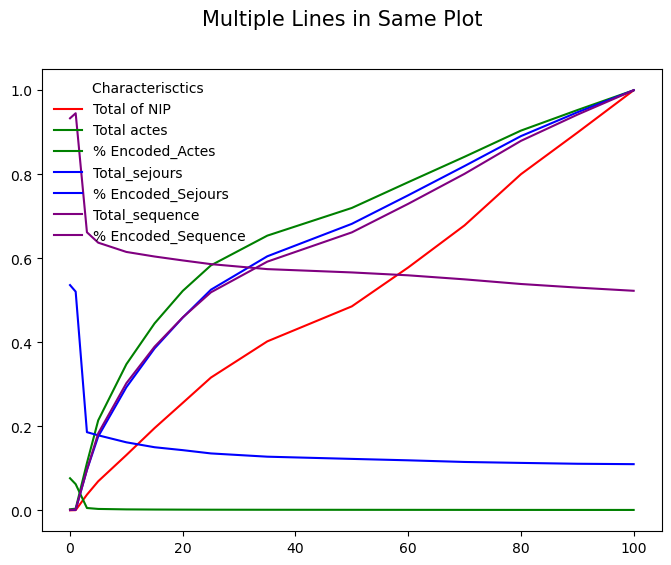

In [42]:
#import matplotlib.pyplot as plt

# The data : Df_Parcours
x =  Df_Parcours['Name']
y1 = Df_Parcours['Total_NIP'].apply(lambda x: x/Df_Parcours['Total_NIP'].max())
y2 = Df_Parcours['Total actes'].apply(lambda x: x/Df_Parcours['Total actes'].max())
y3 = Df_Parcours['Total_sejours'].apply(lambda x: x/Df_Parcours['Total_sejours'].max())
y4 = Df_Parcours['Total_sequence'].apply(lambda x: x/Df_Parcours['Total_sequence'].max())

y2_1 = Df_Parcours['% Encoded_Actes']
y3_1 = Df_Parcours['% Encoded_Sejours']
y4_1 = Df_Parcours['% Encoded_Sequence']

# Initialise the figure and axes.
fig, ax = plt.subplots(1, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Multiple Lines in Same Plot', fontsize=15)

# Draw all the lines in the same plot, assigning a label for each one to be
# shown in the legend.
ax.plot(x, y1, color="red", label="Total of NIP")

ax.plot(x, y2, color="green", label="Total actes")
ax.plot(x, y2_1, color="green", label="% Encoded_Actes")

ax.plot(x, y3, color="blue", label="Total_sejours")
ax.plot(x, y3_1, color="blue", label="% Encoded_Sejours")

ax.plot(x, y4, color="purple", label="Total_sequence")
ax.plot(x, y4_1, color="purple", label="% Encoded_Sequence")



# Add a legend, and position it on the lower right (with no box)
plt.legend(loc="best", title="Characterisctics ", frameon=False)

plt.show()

In [46]:
Table_Liste_Actes = 'A_Actes_ICO_2018_2021_TRIMED' #INCRIT EN DUR DANS LA PROC SQL !!
Table_Actes_filtres ='Tmp_Py_A_Actes_Export'
Site='2'
My_filter_1rst_date=datetime.strptime('11-01-2019 00:00:00', '%m-%d-%Y %H:%M:%S')
My_filter_2nd_date=datetime.strptime('11-01-2019 00:01:00', '%m-%d-%Y %H:%M:%S')

Requete = ' EXECUTE Delete_Table_if_exists ' + Table_Actes_filtres
Requete += ' EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE ' + Table_Liste_Actes + ','+ Table_Actes_filtres + ',\'' + My_filter_1rst_date.strftime('%Y-%m-%d %H:%M:%S') + '\',\'' + My_filter_2nd_date.strftime('%Y-%m-%d %H:%M:%S') + '\','  + Site
print(Requete)

#print(Requete)
print("STEP 1.1 : Filter NIP ON /n Site = " + Site + "/n Date1  = " + str(My_filter_1rst_date)  + " - Date2  = " + str(My_filter_2nd_date) + " - launched at " + str(datetime.now()))
F_SQL_Execute(cnxn,Requete,pyodbc)

 EXECUTE Delete_Table_if_exists Tmp_Py_A_Actes_Export EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE A_Actes_ICO_2018_2021_TRIMED,Tmp_Py_A_Actes_Export,'2019-11-01 00:00:00','2019-11-01 00:01:00',2
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-11-01 00:00:00 - Date2  = 2019-11-01 00:01:00 - launched at 2023-07-19 18:55:54.257802
     F_SQL_Execution - OK


In [3]:
Table_Liste_Actes = 'A_Actes_ICO_2018_2021_TRIMED' #INCRIT EN DUR DANS LA PROC SQL !!
Table_Actes_filtres ='Tmp_Py_A_Actes_Export'
Site='2'
My_filter_date=datetime.strptime('09-06-2019', '%m-%d-%Y')

Requete = ' EXECUTE Delete_Table_if_exists ' + Table_Actes_filtres
Requete += ' EXECUTE Preproc_A0_Filter_NIP_BY_DATE_AND_SITE ' + Table_Liste_Actes + ','+ Table_Actes_filtres + ',' + str(My_filter_date.day) + ',' + str(My_filter_date.month) + ',' + str(My_filter_date.year) +',' + Site

#print(Requete)
print("STEP 1.1 : Filter NIP ON /n Site = " + Site + "/n Date = " + str(My_filter_date) + " - launched at " + str(datetime.now()))
F_SQL_Execute(cnxn,Requete,pyodbc)

#Mise en forme du dataset (Création J0V1234, Date_sejour)
print("STEP 1.2 : Prepare_Data_set - launched at " + str(datetime.now()))
Requete = ' EXECUTE Preproc_B1_Prepare_Dataset ' + Table_Actes_filtres + ',' + 'Listing_UF_V3' + ',' + 'NO' #Table acte / Table_UF / Summary YES -> just first 2000 lines
F_SQL_Execute(cnxn,Requete,pyodbc)

#Binary Encoding (UF,INX,NGAP,CCAM,UFH)
print("STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at " + str(datetime.now()))
Requete = ' EXECUTE Preproc_B4_Prepare_Dataset_Encoding ' + Table_Actes_filtres + ',' + 'Listing_UF_V3' + ',' + 'NO' #Table acte / Table_UF / Summary YES -> just first 2000 lines
F_SQL_Execute(cnxn,Requete,pyodbc)




STEP 1.1 : Filter NIP ON /n Site = 2/n Date = 2019-09-06 00:00:00 - launched at 2023-07-19 13:37:45.082339
     F_SQL_Execution - OK
STEP 1.2 : Prepare_Data_set - launched at 2023-07-19 13:37:49.158695
     F_SQL_Execution - OK
STEP 1.3 : Prepare_Data_set - One Hot Encoding Categories - launched at 2023-07-19 13:37:54.561707
     F_SQL_Execution - OK


In [29]:
#Share results of encoding
    #1 NB of encoded actes / Total of actes

Requete = 'SELECT COUNT([ID_A]) as Total FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]'
Actes_Total=F_SQL_Requete(cnxn,Requete,pyodbc)
Requete = 'SELECT COUNT([Cle_Encode_acte]) as Total FROM [ICO_Activite].[dbo].[Tmp_Acte_Binary_Table]'
Actes_Encoded=F_SQL_Requete(cnxn,Requete,pyodbc)

Actes_percent_encoded=float(Actes_Encoded.loc[0,'Total'])/float(Actes_Total.loc[0,'Total'])
print(str(Actes_Encoded.loc[0,'Total']) + " Actes encoded on  " + str(Actes_Total.loc[0,'Total']) + ' in total ' + str(int(Actes_percent_encoded*100)) +'%')


    #2 NB of encoded Sejours / Total of Sejours

Requete = 'SELECT COUNT(DISTINCT [N_S]) as Total FROM [ICO_Activite].[dbo].[Tmp_Sejour_Encoded]'
Sejours_Total=F_SQL_Requete(cnxn,Requete,pyodbc)
Requete = 'SELECT COUNT([Cle_Encode_Sejour]) as Total FROM [ICO_Activite].[dbo].[Tmp_Sejour_Binary_Table]'
Sejours_Encoded=F_SQL_Requete(cnxn,Requete,pyodbc)

Sejours_percent_encoded=float(Sejours_Encoded.loc[0,'Total'])/float(Sejours_Total.loc[0,'Total'])
print(str(Sejours_Encoded.loc[0,'Total']) + " Sejours encoded on  " + str(Sejours_Total.loc[0,'Total']) + ' in total ' + str(int(Sejours_percent_encoded*100)) +'%')


    #3 NB of encoded Sequences / Total of Sequences

Requete = 'SELECT COUNT(DISTINCT [id_Sequence]) as Total FROM [ICO_Activite].[dbo].[Tmp_Sequence_Encoded]'
Sequence_Total=F_SQL_Requete(cnxn,Requete,pyodbc)
Requete = 'SELECT COUNT([Cle_Encode_Sequence]) as Total FROM [ICO_Activite].[dbo].[Tmp_Sequence_Binary_Table]'
Sequence_Encoded=F_SQL_Requete(cnxn,Requete,pyodbc)

Sequence_percent_encoded=float(Sequence_Encoded.loc[0,'Total'])/float(Sequence_Total.loc[0,'Total'])
print(str(Sequence_Encoded.loc[0,'Total']) + " Sequences encoded on  " + str(Sequence_Total.loc[0,'Total']) + ' in total ' + str(int(Sequence_percent_encoded*100)) +'%')
    #4 NB of Parcours / Total of NIP

     F_SQL_Requete - OK
     F_SQL_Requete - OK
987 Actes encoded on  97659 in total 1%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
5239 Sejours encoded on  23848 in total 21%
     F_SQL_Requete - OK
     F_SQL_Requete - OK
4467 Sequences encoded on  6057 in total 73%


C:\Users\vince\AppData\Local\Temp\ipykernel_18240\1860047965.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_18240\1860047965.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_18240\1860047965.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
C:\Users\vince\AppData\Local\Temp\ipykernel_18240\1860047965.py:4: UserWarning: pa

In [15]:
Actes_Total.loc[0,'Total']

97659

#SE TROUVE A PRESENT DISPONIBLE DANS LA BDD 
# Listing_UF_V3
# Tmp_A_Actes_Table_Analyse - Base de donnée d'activité filtrée par le NIP dont les colonnes sont normalisées
    # ID_A / NIP / N_S / DD_A / DF_A / DD_M / HD_M / DF_M / HF_M / UFX / INX / R_NGAP / R_CCAM / UFH / Statut / Code_Equip / Site 
# Tmp_PS_
    # NIP / N_S / J0V1 / J0V2 / Poids_Sejour_DS / Poids_Sejour_DSOS 
# Tmp_Type_Sequence
    # NIP / id_Seq / N_S / J0V3 / J0V4 / Type_Sequence 

# ***********************     STEP 2 - LOADING DATASET OF PATIENTS     ***************************

In [5]:
#Definition des tables d'entrée
#Tble_Liste_Actes = Table_Actes_filtres
#Tble_UF ='Table_UF'
Requete = Req_SQL.Req_Export_Acte
df_acte=F_SQL_Requete(cnxn,Requete,pyodbc)

Requete=Req_SQL.Req_Export_Sejours
df_sejour=F_SQL_Requete(cnxn,Requete,pyodbc)

#print(df)


C:\Users\vince\AppData\Local\Temp\ipykernel_1188\2348285024.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


     F_SQL_Requete - OK
     F_SQL_Requete - OK


## 1st show the maximum detail level (Actes)

In [4]:
df_acte.columns

NameError: name 'df_acte' is not defined

In [6]:
df_acte.head()

,NIP,ID_A,N_S,id_Sequence,J0_V1,J0_V2,J0_V3,J0_V4,J_V1,J_V2,...,INX,R_NGAP_CCAM_UFH,Statut,Code_Equip,Service,Phase_Parcours,Activite,Site,Source,Type_Sequence
0,N199501208,13671446,N1600206,175,2018-01-02,2018-11-27,1995-07-01,1995-07-01,0,-329,...,7706,514,E,,Laboratoire,Diagnostic,Diagnostic,2,NGAP,INIT_OLD
1,N199501208,13671447,N1600206,175,2018-01-02,2018-11-27,1995-07-01,1995-07-01,0,-329,...,7706,519,E,,Laboratoire,Diagnostic,Diagnostic,2,NGAP,INIT_OLD
2,N199501208,13671448,N1600206,175,2018-01-02,2018-11-27,1995-07-01,1995-07-01,0,-329,...,7706,521,E,,Laboratoire,Diagnostic,Diagnostic,2,NGAP,INIT_OLD
3,N199501208,13671449,N1600206,175,2018-01-02,2018-11-27,1995-07-01,1995-07-01,0,-329,...,7706,522,E,,Laboratoire,Diagnostic,Diagnostic,2,NGAP,INIT_OLD
4,N199501208,13671450,N1600206,175,2018-01-02,2018-11-27,1995-07-01,1995-07-01,0,-329,...,7706,552,E,,Laboratoire,Diagnostic,Diagnostic,2,NGAP,INIT_OLD


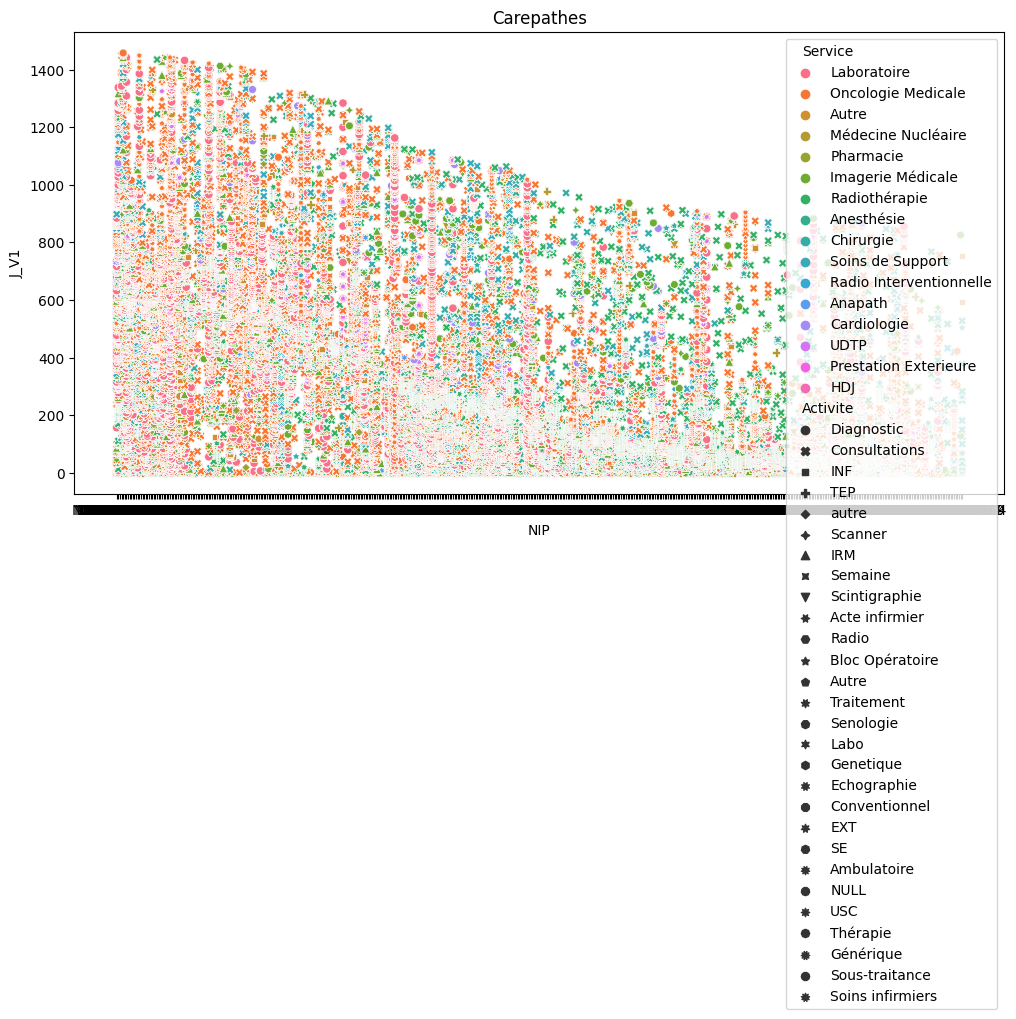

In [7]:

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.set_title('Carepathes')
sns.scatterplot(data=df_acte, x='NIP', y='J_V1',hue='Service', style='Activite')
#axs.flat[1].set_title('ratings_count boxplot')
#sns.boxplot(data=df, x='ratings_count', ax=axs[1])

plt.show()

## 2nd show the first level of aggregation (Sejour)

In [8]:
df_sejour.columns

Index(['NIP', 'N_S', 'id_Sequence', 'Type_Sequence', 'J0_V1', 'J0_V2', 'J0_V3',
       'J0_V4', 'J_V1', 'J_V2', 'J_V3', 'J_V4', 'DD_S', 'DF_S',
       'Duree_Sejour_j', 'Id_A_Caracteristique', 'C_UFX', 'C_INX',
       'C_R_NGAP_CCAM_UFH', 'C_Statut', 'C_Code_Equip', 'C_Service',
       'C_Phase_Parcours', 'C_Activite', 'C_Site', 'C_Source'],
      dtype='object')

In [9]:
df_acte.head()

,NIP,ID_A,N_S,id_Sequence,J0_V1,J0_V2,J0_V3,J0_V4,J_V1,J_V2,...,INX,R_NGAP_CCAM_UFH,Statut,Code_Equip,Service,Phase_Parcours,Activite,Site,Source,Type_Sequence
0,N201204788,501710,N1605690,342,2018-01-15,2019-03-01,2012-07-01,2012-07-01,0,-410,...,6843,DAQL002,E,,Médecine Nucléaire,Diagnostic,Scintigraphie,2,CCAM,INIT_OLD
1,N201507132,561832,N1606070,453,2018-01-15,2018-03-21,2015-07-01,2015-07-01,0,-65,...,10687,QEQK005,E,,Imagerie Médicale,Diagnostic,Senologie,2,CCAM,INIT_OLD
2,N201100317,537166,N1611888,298,2018-01-26,2018-02-16,2011-07-01,2011-07-01,0,-21,...,6828,QEJA001,E,,Autre,Soins,INF,2,CCAM,INIT_OLD
3,N201704012,561718,N1614061,596,2018-01-31,2019-02-13,2017-07-01,2017-07-01,0,-378,...,6853,YYYY600,H,,Imagerie Médicale,Diagnostic,Scanner,2,CCAM,INIT_OLD
4,N201801031,486369,N1621569,675,2018-02-15,2020-11-19,2018-02-15,2020-11-19,0,-1008,...,VEVER,ZZQX069,H,,Anapath,Diagnostic,Labo,2,CCAM,INIT_NEW


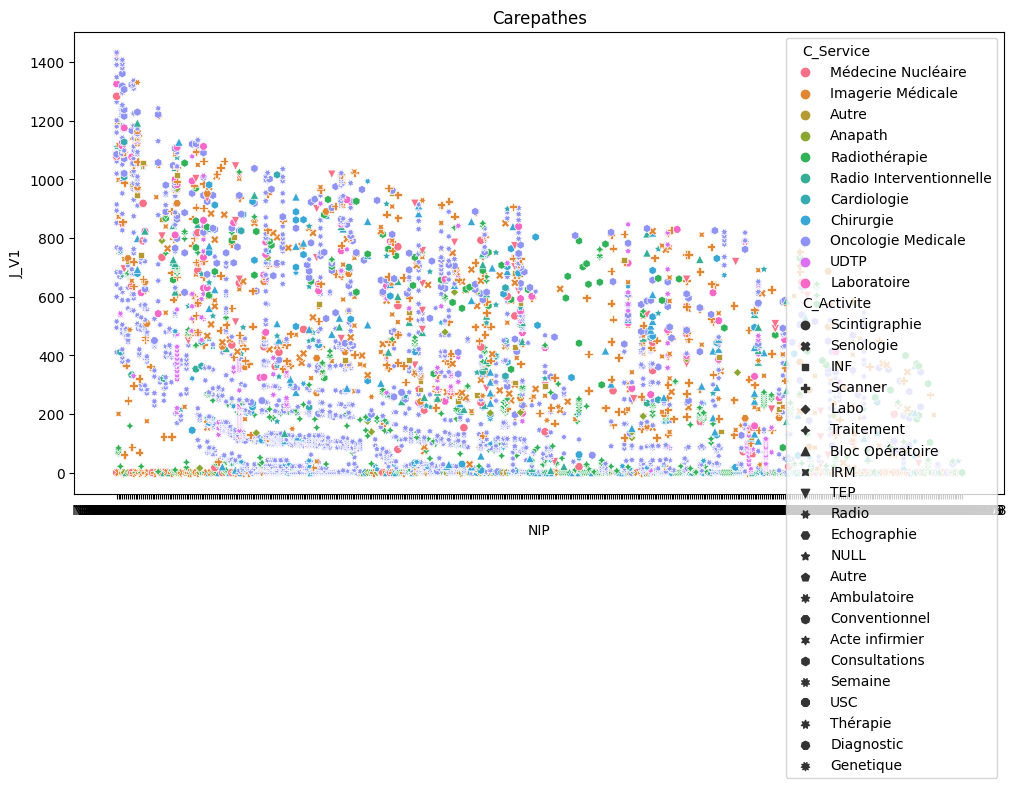

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.set_title('Carepathes')
sns.scatterplot(data=df_sejour, x='NIP', y='J_V1',hue='C_Service', style='C_Activite')
#axs.flat[1].set_title('ratings_count boxplot')
#sns.boxplot(data=df, x='ratings_count', ax=axs[1])

plt.show()

## 3rd show the second level of aggregation (Sequence)

## 4th show the third level of aggregation (Patient)

In [9]:
from sklearn.cluster import KMeans
import numpy as np
X = df
KMeans.fit(X)



AttributeError: 'DataFrame' object has no attribute '_validate_params'